# Head Pose Prediction

## Installing MediaPipe

In [1]:
# %%capture
# !pip install mediapipe

## Required Libraries

In [145]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
# from google.colab.patches import cv2_imshow

## Dowlining Data

In [144]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

Image loaded successfully with shape: (450, 450, 3)


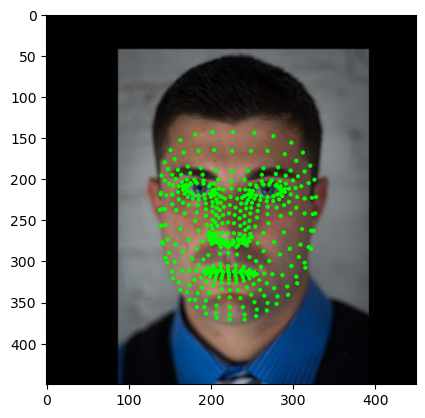

In [6]:
random_file = 'image00028'

faceModule = mediapipe.solutions.face_mesh
# loading image and its corresponding mat file
image_path = './AFLW2000-3D/X/' + random_file + '.jpg'
image = cv2.imread(image_path)

if image is None:
    print("Error: Unable to load image from path:", image_path)
else:
    print("Image loaded successfully with shape:", image.shape)

with faceModule.FaceMesh(static_image_mode=True) as faces:
    if image is not None:
        # processing the face to extract the landmark points (468 points) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks is not None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixels = np.array(image)
        plt.imshow(pixels)

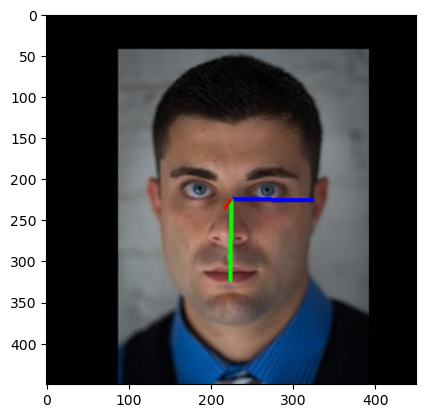

In [7]:
image = cv2.imread('./AFLW2000-3D/X/' + random_file + '.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('./AFLW2000-3D/y/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = np.array(image)
plt.imshow(draw_axis(image,pitch,yaw,roll))


## Preparing Data

In [6]:

faceModule = mediapipe.solutions.face_mesh
# loading image and its corresponding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    folder_path = r"D:\ITI 9-Month\12- Machine Learning\Project\AFLW2000-3D\X"
    files = os.listdir(folder_path)
    image_files = [file for file in files]
    inhomogeneous_images = []
    all_data = []
    ihnomognous_imgaes = []
    for img in image_files:
        path = folder_path +'\\'+img
        image = cv2.imread(path)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        arr = []
        if results.multi_face_landmarks is not None: 
          # looping over the faces in the image 
          for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    arr.append([relative_x, relative_y])
        
        if np.shape(arr)[0] !=  0:
            all_data.append(list(np.array(arr).reshape(1,-1)))
        else:
            inhomogeneous_images.append(img)
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)    
    print(np.shape(all_data))

In [7]:
all_data = np.array(all_data).reshape(1853,936)

In [8]:
imgs_not_found = [img.split('.')[0] for img in inhomogeneous_images]

In [9]:
folder_path = r"D:\ITI 9-Month\12- Machine Learning\Project\AFLW2000-3D\y"
files = os.listdir(folder_path)
image_files = [file for file in files]
y_angles = []
for img in image_files:
    if img.split('.')[0] not in imgs_not_found:
        path = folder_path +'\\'+img
        mat_file = sio.loadmat(path)
        pose_para = mat_file["Pose_Para"][0][:3]

        # extracting the labels 3 angles
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2]

        y_angles.append([pitch, yaw, roll])


In [10]:
np.shape(y_angles)

In [11]:
y_angles = np.array(y_angles)

In [12]:
X = pd.DataFrame(all_data)
y = pd.DataFrame(y_angles)

In [13]:
X.to_csv('features.csv', index=False)
y.to_csv('labels.csv', index=False)

## Loading Data

In [50]:
X = pd.read_csv('features.csv')
y = pd.read_csv('labels.csv')

In [51]:
y.shape

(1853, 3)

## Data Preprocessing

In [52]:
def preprocessing_features(matrix):
    full_mat_arr = np.array(matrix)
    x = full_mat_arr[:,::2]
    y = full_mat_arr[:,1::2]

    min_x = x.min(axis=1).reshape(-1,1)
    max_x = x.max(axis=1).reshape(-1,1)
    
    min_y = y.min(axis=1).reshape(-1,1)
    max_y = y.max(axis=1).reshape(-1,1)
    
    x_normalized = (x-min_x)/(max_x - min_x)
    y_normalized = (y-min_y)/ (max_y - min_y)

    matrix_normalized = np.concatenate((x_normalized, y_normalized), axis=1)
    return matrix_normalized

In [53]:
data_mat = np.array(X)
data_normalized = preprocessing_features(data_mat)

In [55]:
np.shape(data_normalized)

(1853, 936)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_normalized, y, test_size=0.2, random_state=42)

###  XGBOOST

In [27]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
xgb_regressor = MultiOutputRegressor(xgb.XGBRegressor())

xgb_regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [28]:
print(f'Score in Train: {xgb_regressor.score(X_train, y_train)}')
print(f'Score in test: {xgb_regressor.score(X_test, y_test)}')

Score in Train: 0.9999191451436839
Score in test: -1.2786764283876313


### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression().fit(X_train,y_train)

In [32]:
print(f'Score in Train: {lr_model.score(X_train, y_train)}')
print(f'Score in test: {lr_model.score(X_test, y_test)}')

Score in Train: 0.8323587218698106
Score in test: -3.6423091433053307


### Ridge

In [71]:
from sklearn.linear_model import Ridge

ridge_model = Ridge() 
ridge_model.fit(X_train , y_train)

Ridge()

In [72]:
print(f'Score in Train: {ridge_model.score(X_train, y_train)}')
print(f'Score in test: {ridge_model.score(X_test, y_test)}')

Score in Train: 0.46255731185388754
Score in test: 0.6958404916255051


### RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [27]:
print(f'Score in Train: {rf_model.score(X_train, y_train)}')
print(f'Score in test: {rf_model.score(X_test, y_test)}')

Score in Train: 0.8865499870269972
Score in test: -0.03991122297824493


### SVM

In [84]:
from sklearn.svm import SVR
svr_model = MultiOutputRegressor(SVR())
svr_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

In [34]:
print(f'Score in Train: {svr_model.score(X_train, y_train)}')
print(f'Score in test: {svr_model.score(X_test, y_test)}')

Score in Train: 0.433756938300097
Score in test: 0.8486255311537109


In [85]:
y_pred_train = svr_model.predict(X_train)
y_pred_test = svr_model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f'MAE in Train: {mae_train}')
print(f'MAE in test: {mae_test}')

MAE in Train: 0.08922785968657275
MAE in test: 0.06752110021052565


### Best Algorithm is SVR, So I will make a huyper parameter tuning using grid search

In [30]:


svr = SVR()

svr_model = MultiOutputRegressor(svr)

# Define the parameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__degree': [2, 3, 4],  # Only for poly kernel
    'estimator__epsilon': [0.1, 0.2, 0.3],  # Epsilon in the epsilon-SVR model
    'estimator__shrinking': [True, False]  # Whether to use the shrinking heuristic
}

# Perform grid search
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Fit the SVR model with the best parameters
svr_model.set_params(**best_params)
svr_model.fit(X_train, y_train)

# Use the fitted model for predictions
y_pred = svr_model.predict(X_test)

In [31]:
best_params

{'estimator__C': 10,
 'estimator__degree': 2,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'poly',
 'estimator__shrinking': True}

In [83]:


# Define SVR model
svr = SVR(kernel='poly', degree=2, epsilon=0.1, gamma='scale', C=10)

# Wrap SVR model with MultiOutputRegressor
svr_model = MultiOutputRegressor(svr)

num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds)

# Lists to store scores for each fold
cv_scores = []
cv_maes = []

# Convert y to a numpy array if it's not already
y = np.array(y)

# Perform k-fold cross-validation
for train_index, val_index in kf.split(data_normalized):
    X_train_fold, X_val_fold = data_normalized[train_index], data_normalized[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Fit SVR model on training fold
    svr_model.fit(X_train_fold, y_train_fold)

    # Predict on validation fold
    y_pred = svr_model.predict(X_val_fold)

    # Calculate mean absolute error
    fold_mae = mean_absolute_error(y_val_fold, y_pred)
    cv_maes.append(fold_mae)

# Calculate mean cross-validation MAE
mean_cv_mae = np.mean(cv_maes)

print(f'Mean cross-validation MAE: {mean_cv_mae}')

Mean cross-validation MAE: 0.086477990871652


### Predict the axis

In [138]:
def get_prediction(image , features ,model , flag=1):
    features_tran = preprocessing_features(features)
    pose_para = model.predict(features_tran)
    print(pose_para)
    print(pose_para.shape)
    pitch = pose_para[0][0]
    yaw = pose_para[0][1]
    roll = pose_para[0][2]
    mat_arr = np.array(features)
    
    tx = (mat_arr[0][::2]*image.shape[1]).mean(axis=0) 
    ty = (mat_arr[0][1::2]*image.shape[0]).mean(axis=0)


    if flag ==1:
        cv2.imshow('image' , draw_axis(image,pitch,yaw,roll , tx,ty))
        cv2.waitKey(0)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixels = np.array(image)
        plt.imshow(pixels)
    
    return draw_axis(image,pitch,yaw,roll , tx,ty)

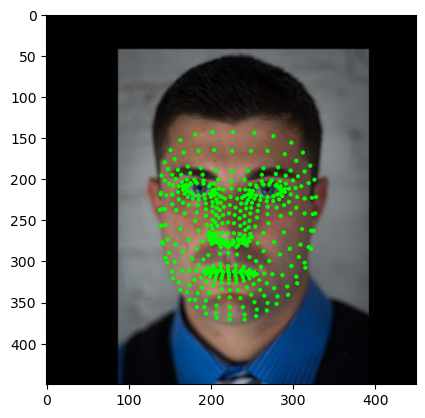

In [139]:
# choosing random image
random_file = 'image00028'
matrix1 = []
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image_path = './AFLW2000-3D/X/' + random_file + '.jpg'
    image = cv2.imread(image_path)
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    j=0
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                #matrix.append([x,y])
                if j==0:
                    matrix1.append([x,y])
                    j=1
                else:
                    matrix1[0].extend([x,y])

                
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.imshow(pixels)


[[-0.07582991  0.07220354  0.01144563]]
(1, 3)


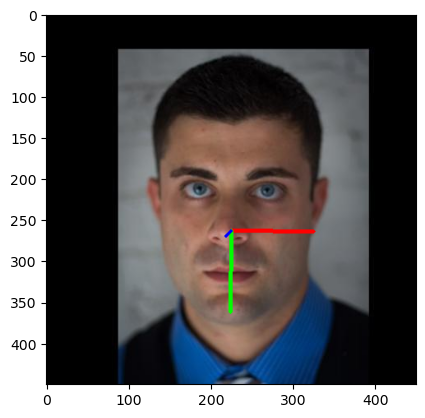

In [140]:
random_file = 'image00028'
image_path = './AFLW2000-3D/X/' + random_file + '.jpg'
image = cv2.imread(image_path)
axis = get_prediction(image , matrix1 ,svr_model)

## Test the model of Video

In [146]:
input_video = cv2.VideoCapture("my_video.mp4")

# Get the video properties
fps = input_video.get(cv2.CAP_PROP_FPS)
width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create VideoWriter object to write the processed frames
output_video = cv2.VideoWriter('Final_video.mp4', 
                                cv2.VideoWriter_fourcc(*'mp4v'), 
                                fps, 
                                (width, height))

# Process each frame
while input_video.isOpened():
    ret, frame = input_video.read()

    if not ret:
        break


    processed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    matrix1 = []
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        j=0
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    #matrix.append([x,y])
                    if j==0:
                        matrix1.append([x,y])
                        j=1
                    else:
                        matrix1[0].extend([x,y])
    
    
    
            processed_frame = get_prediction(frame , matrix1 ,svr_model , 0) #I will use svr which give best accuracy
        
        else:
            processed_frame = frame
    
    output_video.write(processed_frame)


# Release video objects
input_video.release()
output_video.release()
cv2.destroyAllWindows()

[[ 0.06162636 -0.01266878 -0.05671669]]
(1, 3)
[[ 0.0566988 -0.0108995 -0.053739 ]]
(1, 3)
[[ 0.07336301 -0.01219535 -0.05652477]]
(1, 3)
[[ 0.07400568 -0.01046094 -0.05310741]]
(1, 3)
[[ 0.06466248 -0.00662624 -0.05678954]]
(1, 3)
[[ 0.05600188 -0.00908102 -0.05908578]]
(1, 3)
[[ 0.07203094 -0.01042243 -0.05906607]]
(1, 3)
[[ 0.0597141  -0.00820931 -0.05756864]]
(1, 3)
[[ 0.07197632 -0.00412262 -0.05283275]]
(1, 3)
[[ 0.07231286 -0.01223664 -0.05338058]]
(1, 3)
[[ 0.08037498 -0.01681768 -0.05692503]]
(1, 3)
[[ 0.08913098 -0.02025254 -0.05335165]]
(1, 3)
[[ 0.08289135 -0.01890369 -0.05142641]]
(1, 3)
[[ 0.07090626 -0.0167089  -0.05523365]]
(1, 3)
[[ 0.07921813 -0.00893527 -0.05630473]]
(1, 3)
[[ 0.0731581  -0.01215922 -0.05291618]]
(1, 3)
[[ 0.08125921 -0.01507188 -0.05420958]]
(1, 3)
[[ 0.07368298 -0.01929618 -0.05508572]]
(1, 3)
[[ 0.07368667 -0.01391483 -0.05939368]]
(1, 3)
[[ 0.05983039 -0.01587195 -0.05855378]]
(1, 3)
[[ 0.06857204 -0.02204543 -0.05861606]]
(1, 3)
[[ 0.06795963 -0

[[ 0.55876672  0.07088128 -0.09074336]]
(1, 3)
[[ 0.55449775  0.01709828 -0.09612479]]
(1, 3)
[[ 0.53221135  0.06506377 -0.10979828]]
(1, 3)
[[ 0.5787705   0.07661847 -0.07747282]]
(1, 3)
[[ 0.57044121  0.05486027 -0.06594299]]
(1, 3)
[[ 0.63135664 -0.00883066 -0.08117242]]
(1, 3)
[[ 0.63402961 -0.01204497 -0.08873171]]
(1, 3)
[[ 0.62185613 -0.02973485 -0.10871267]]
(1, 3)
[[ 0.56219526 -0.00098353 -0.1070619 ]]
(1, 3)
[[ 0.52932297  0.00509306 -0.09737343]]
(1, 3)
[[ 0.51998156 -0.01484091 -0.12100533]]
(1, 3)
[[ 0.60390691 -0.03007908 -0.10258841]]
(1, 3)
[[ 0.57233512 -0.00450965 -0.14517545]]
(1, 3)
[[ 0.55227796  0.00210365 -0.15006349]]
(1, 3)
[[ 0.54381979 -0.00975772 -0.13198131]]
(1, 3)
[[ 0.51906445 -0.00451452 -0.12257072]]
(1, 3)
[[ 0.50175615 -0.00845542 -0.11671184]]
(1, 3)
[[ 0.47284284 -0.01042526 -0.1133173 ]]
(1, 3)
[[ 0.42560806  0.00472073 -0.10370089]]
(1, 3)
[[ 0.40673792  0.00369074 -0.10083617]]
(1, 3)
[[ 0.39167727  0.0199725  -0.10000231]]
(1, 3)
[[ 0.3732245 

[[ 0.34994119 -0.82348865 -0.43732233]]
(1, 3)
[[ 0.38352771 -0.89890716 -0.45577754]]
(1, 3)
[[ 0.43258593 -0.94823518 -0.46521252]]
(1, 3)
[[ 0.40175834 -0.93114755 -0.47534938]]
(1, 3)
[[ 0.39007281 -0.98119938 -0.45309527]]
(1, 3)
[[ 0.44569977 -1.01245009 -0.44332838]]
(1, 3)
[[ 0.47557465 -1.0106293  -0.45719147]]
(1, 3)
[[ 0.51913163 -1.03382098 -0.4719694 ]]
(1, 3)
[[ 0.47415774 -1.03541969 -0.42306494]]
(1, 3)
[[ 0.44264285 -1.03100002 -0.40248359]]
(1, 3)
[[ 0.4368097  -1.03718197 -0.39554659]]
(1, 3)
[[ 0.46800908 -1.02425159 -0.39757013]]
(1, 3)
[[ 0.39222077 -1.01559352 -0.39138395]]
(1, 3)
[[ 0.40269646 -1.00659194 -0.3858744 ]]
(1, 3)
[[ 0.35954755 -0.991357   -0.35513533]]
(1, 3)
[[ 0.33699414 -0.94996682 -0.32868037]]
(1, 3)
[[ 0.25365129 -0.91182268 -0.30684436]]
(1, 3)
[[ 0.25778136 -0.86047414 -0.30502905]]
(1, 3)
[[ 0.19406507 -0.74475674 -0.2457626 ]]
(1, 3)
[[ 0.17181338 -0.64663082 -0.22842704]]
(1, 3)
[[ 0.07311047 -0.55793229 -0.16540875]]
(1, 3)
[[ 0.09982933